# Aplicação do algoritmo de estimação de pose utilizando Blaze Pose

--> Primeiramente chamam-se as bibliotecas de código aberto necessárias para a implementação do código em Python, OpenCV e MediaPipe.

In [99]:
import cv2
import mediapipe as mp
import numpy as np
from numpy import asarray
from numpy import save

--> Inicializando as classes e funções necessárias para as estimativas executadas pela rede neural.

In [100]:
# Initializing mediapipe drawing class, useful for annotation.
mp_drawing = mp.solutions.drawing_utils

# Initializing mediapipe pose class.
mp_pose = mp.solutions.pose

# Setting up the Pose function.
pose = mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence = 0.5)

--> Escolhendo o vídeo de entrada do algoritmo. Neste caso, está sendo usado o vídeo de nome gaitest.mp4, insira o nome do seu arquivo de vídeo no lugar e lembre-se de tê-lo dentro da mesma pasta em que o código foi salvo.

--> Estabelecendo 1000 como o número utilizado para converter as coordenadas do mundo real de metros para milímetros.

In [101]:
# Getting the input video for pose estimation
cap = cv2.VideoCapture('gaitest4.mp4')

# Number to convert the real world coordinate from meters to milimeters
num = 1000

--> Criando um dicionário para definir os segmentos do corpo correspondentes ao modelo de corpo humano da rede neural

In [102]:
# Landmarks dictionary to define body segments landmarks according to BlazePose Topology
landmarks_coordinates = {}

thigh_segments = {"Left Thigh": [23, 25], "Right Thigh": [24, 26]}

upperarm_segments = {"Left Upper Arm": [11, 13], "Right Upper Arm": [12, 14]}

forearm_segments = {"Left Fore Arm": [13, 15], "Right Fore Arm": [14, 16]}

leg_segments = {"Left Leg": [25, 27], "Right Leg": [26, 28]}

foot_segments = {"Left foot": [27, 31], "Right foot": [28, 32]}

hands_segments = {"Left hand": [15, 19], "Right hand": [16, 20]}

shoulder_segment = {"Shoulder": [12, 11]}

hips_segment = {"Hips": [24, 23]}

trunk_segment = {"trunk": [34, 33]}

--> Definindo as funções para cálculo do CoM de cada segmento corporal

In [103]:
# Function to calculate CoM coordinates for segments defined in the dictionary

def calculate_foot_CoM(x_i, x_j, y_i, y_j):
    x1 = (x_i + x_j) * 0.5
    y1 = (y_i + y_j) * 0.5

    return x1, y1


def calculate_Leg_CoM(x_g, x_h, y_g, y_h):
    x2 = x_g + 0.433 * (x_h - x_g)
    y2 = y_g - 0.433 * (y_g - y_h)

    return x2, y2


def calculate_thigh_CoM(x_a, x_b, y_a, y_b):
    x3 = x_a + 0.433 * (x_b - x_a)
    y3 = y_a - 0.433 * (y_a - y_b)

    return x3, y3


def calculate_UpperArm_CoM(x_c, x_d, y_c, y_d):
    x4 = x_c + 0.436 * (x_d - x_c)
    y4 = y_c - 0.436 * (y_c - y_d)

    return x4, y4


def calculate_ForeArm_CoM(x_e, x_f, y_e, y_f):
    x5 = x_e + 0.430 * (x_f - x_e)
    y5 = y_e - 0.430 * (y_e - y_f)

    return x5, y5


def calculate_hands_CoM(x_o, x_p, y_o, y_p):
    x6 = x_o + 0.506 * (x_p - x_o)
    y6 = y_o - 0.506 * (y_o - y_p)

    return x6, y6


def calculate_trunk_CoM(x_q, x_r, y_q, y_r):
    x7 = x_q - 0.66 * (x_q - x_r)
    y7 = y_q - 0.66 * (y_q - y_r)

    return x7, y7


def calculate_average(x_l, x_r, y_l, y_r):
    x = (x_l + x_r) * 0.5
    y = (y_l + y_r) * 0.5

    return x, y

--> Código para a estimativa da trajetória do CoM

--> Caso 1: Abrir uma janela com o vídeo mostrando a estimativa de pose e CoM, basta descomentar esta linha no fim do código "#cv2.imshow("Video", image)".

--> Caso 2: Ver as coordenadas do CoM do corpo todo em pixels, troque pose_world_landmarks por pose_landmarks na linha de código: "for idx, lm in enumerate(results.pose_world_landmarks.landmark):" e apague "num" do cálculo do CoM nas linhas "body_com_x = num*(0.0145 * foot_com_x + ..." e "body_com_y = num*(0.0145 * foot_com_y + ..." no fim do código.

Obs: As coordenadas para o CoM do corpo todo aparecerão logo após o seguinte bloco.

In [104]:
### Pose estimation for one individual in a video

# While the video is running, perform pose detection 
while True:
    success, image = cap.read()
    results = pose.process(image)
    
    # Defining a variable to calculate the whole body CoM in the end, by getting
    # all the segment´s CoM coordinates values
    com_body = 0
    
    # Check if any landmarks are found.
    if results.pose_world_landmarks:
        # draw the connections between joint landmarks
        mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS,
                                mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=2), 
                                mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2) 
                                 ) 
        # Enumerate each landmark according to BlazePose Topology 
        for idx, lm in enumerate(results.pose_world_landmarks.landmark):
            h, w, c = image.shape
            cx, cy = int(lm.x * w), int(lm.y * h)
            #cv2.circle(image, (cx, cy), 2, (0, 0, 255), cv2.FILLED)
            #if idx == 11:
            #    print(idx, lm.x, lm.y, lm.z)
            landmarks_coordinates[idx] = {"x": lm.x, "y": -lm.y}

       # Calculating trunk CoM coordinates by defining the average point in the shoulder and
        # hips segment
        x_left_shoulder = landmarks_coordinates[shoulder_segment["Shoulder"][1]]["x"]
        y_left_shoulder = landmarks_coordinates[shoulder_segment["Shoulder"][1]]["y"]
        x_right_shoulder = landmarks_coordinates[shoulder_segment["Shoulder"][0]]["x"]
        y_right_shoulder = landmarks_coordinates[shoulder_segment["Shoulder"][0]]["y"]
        x_average_shoulder, y_average_shoulder = calculate_average(
            x_left_shoulder, x_right_shoulder, y_left_shoulder, y_right_shoulder
        )

        landmarks_coordinates[33] = {"x": x_average_shoulder, "y": y_average_shoulder}

        x_left_hips = landmarks_coordinates[hips_segment["Hips"][1]]["x"]
        y_left_hips = landmarks_coordinates[hips_segment["Hips"][1]]["y"]
        x_right_hips = landmarks_coordinates[hips_segment["Hips"][0]]["x"]
        y_right_hips = landmarks_coordinates[hips_segment["Hips"][0]]["y"]
        x_average_hips, y_average_hips = calculate_average(
            x_left_hips, x_right_hips, y_left_hips, y_right_hips
        )

        landmarks_coordinates[34] = {"x": x_average_hips, "y": y_average_hips}

    # Calculate Body segments CoM

    foot_com_x = 0
    foot_com_y = 0
    for segment in foot_segments:
        # print("%s COM:" % segment)
        x_i = landmarks_coordinates[foot_segments[segment][0]]["x"]
        x_j = landmarks_coordinates[foot_segments[segment][1]]["x"]
        y_i = landmarks_coordinates[foot_segments[segment][0]]["y"]
        y_j = landmarks_coordinates[foot_segments[segment][1]]["y"]

        x1, y1 = calculate_foot_CoM(x_i, x_j, y_i, y_j)
        #print("x: %s, y: %s\n" % (str(x1), str(y1)))

        #h, w, c = image.shape
        cx, cy = int(x1*w), int(y1*h)
        # cv2.circle(image, (cx, cy), 5, (255, 0, 0), cv2.FILLED)

        foot_com_x += x1
        foot_com_y += y1

    leg_com_x = 0
    leg_com_y = 0
    for segment in leg_segments:
        # print("%s COM:" % segment)
        x_g = landmarks_coordinates[leg_segments[segment][0]]["x"]
        x_h = landmarks_coordinates[leg_segments[segment][1]]["x"]
        y_g = landmarks_coordinates[leg_segments[segment][0]]["y"]
        y_h = landmarks_coordinates[leg_segments[segment][1]]["y"]

        x2, y2 = calculate_Leg_CoM(x_g, x_h, y_g, y_h)
        # print("x: %s, y: %s\n" % (str(x2), str(y2)))

        #h, w, c = image.shape
        cx, cy = int(x2*w), int(y2*h)
        # cv2.circle(image, (cx, cy), 5, (255, 0, 0), cv2.FILLED)

        leg_com_x += x2
        leg_com_y += y2

    thigh_com_x = 0
    thigh_com_y = 0
    for segment in thigh_segments:
        # print("%s COM:" % segment)
        x_a = landmarks_coordinates[thigh_segments[segment][0]]["x"]
        x_b = landmarks_coordinates[thigh_segments[segment][1]]["x"]
        y_a = landmarks_coordinates[thigh_segments[segment][0]]["y"]
        y_b = landmarks_coordinates[thigh_segments[segment][1]]["y"]

        x3, y3 = calculate_thigh_CoM(x_a, x_b, y_a, y_b)
        #print("x: %s, y: %s\n" % (str(x3), str(y3)))

        #h, w, c = image.shape
        cx, cy = int(x3*w), int(y3*h)
        # cv2.circle(image, (cx, cy), 5, (255, 0, 0), cv2.FILLED)

        thigh_com_x += x3
        thigh_com_y += y3

    upperarm_com_x = 0
    upperarm_com_y = 0
    for segment in upperarm_segments:
        # print("%s COM:" % segment)
        x_c = landmarks_coordinates[upperarm_segments[segment][0]]["x"]
        x_d = landmarks_coordinates[upperarm_segments[segment][1]]["x"]
        y_c = landmarks_coordinates[upperarm_segments[segment][0]]["y"]
        y_d = landmarks_coordinates[upperarm_segments[segment][1]]["y"]

        x4, y4 = calculate_UpperArm_CoM(x_c, x_d, y_c, y_d)
        # print("x: %s, y: %s\n" % (str(x4), str(y4)))

        #h, w, c = image.shape
        cx, cy = int(x4*w), int(y4*h)
        # cv2.circle(image, (cx, cy), 5, (255, 0, 0), cv2.FILLED)
        upperarm_com_x += x4
        upperarm_com_y += y4

    forearm_com_x = 0
    forearm_com_y = 0
    for segment in forearm_segments:
        # print("%s COM:" % segment)
        x_e = landmarks_coordinates[forearm_segments[segment][0]]["x"]
        x_f = landmarks_coordinates[forearm_segments[segment][1]]["x"]
        y_e = landmarks_coordinates[forearm_segments[segment][0]]["y"]
        y_f = landmarks_coordinates[forearm_segments[segment][1]]["y"]

        x5, y5 = calculate_ForeArm_CoM(x_e, x_f, y_e, y_f)
        # print("x: %s, y: %s\n" % (str(x5), str(y5)))

        #h, w, c = image.shape
        cx, cy = int(x5*w), int(y5*h)
        # cv2.circle(image, (cx, cy), 5, (255, 0, 0), cv2.FILLED)
        forearm_com_x += x5
        forearm_com_y += y5

    hands_com_x = 0
    hands_com_y = 0
    for segment in hands_segments:
        # print("%s COM:" % segment)
        x_o = landmarks_coordinates[hands_segments[segment][0]]["x"]
        x_p = landmarks_coordinates[hands_segments[segment][1]]["x"]
        y_o = landmarks_coordinates[hands_segments[segment][0]]["y"]
        y_p = landmarks_coordinates[hands_segments[segment][1]]["y"]

        x6, y6 = calculate_hands_CoM(x_o, x_p, y_o, y_p)
        # print("x: %s, y: %s\n" % (str(x6), str(y6)))

        #h, w, c = image.shape
        cx, cy = int(x6*w), int(y6*h)
        # cv2.circle(image, (cx, cy), 5, (255, 0, 0), cv2.FILLED)

        hands_com_x += x6
        hands_com_y += y6

    trunk_com_x = 0
    trunk_com_y = 0
    for segment in trunk_segment:
        # print("%s COM:" % segment)
        x_q = landmarks_coordinates[trunk_segment[segment][0]]["x"]
        x_r = landmarks_coordinates[trunk_segment[segment][1]]["x"]
        y_q = landmarks_coordinates[trunk_segment[segment][0]]["y"]
        y_r = landmarks_coordinates[trunk_segment[segment][1]]["y"]

        x7, y7 = calculate_trunk_CoM(x_q, x_r, y_q, y_r)
        #print("x: %s, y: %s\n" % (str(x7), str(y7)))

        #h, w, c = image.shape
        cx, cy = int(x7*w), int(y7*h)
        #  cv2.circle(image, (cx, cy), 5, (255, 0, 0), cv2.FILLED)

        trunk_com_x += x7
        trunk_com_y += y7

    # Calculate the whole body CoM
    body_com_x = num*(0.0145 * foot_com_x + 0.0465 * leg_com_x + 0.1 * thigh_com_x + 0.578 * trunk_com_x + 0.006 * hands_com_x + 0.028 * upperarm_com_x + 0.016 * forearm_com_x)
    body_com_y = num*(0.0145 * foot_com_y + 0.0465 * leg_com_y + 0.1 * thigh_com_y + 0.578 * trunk_com_y + 0.006 * hands_com_y + 0.028 * upperarm_com_y + 0.016 * forearm_com_y)
    
    cx, cy = int(body_com_x * w), int(body_com_y * h)
    cv2.circle(image, (cx, cy), 5, (0, 255, 255), cv2.FILLED)
    print("[ %s,  %s],\n" % (str(body_com_x), str(body_com_y)))
    
    # Show the output image with the pose estimation and the CoM plotted
    #cv2.imshow("Video", image)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break


[ 0.5600306987911454,  96.51687590407391],

[ 4.341380694802849,  91.57167561311272],

[ 6.475694956901482,  89.08546636846658],

[ 2.761463008479682,  92.33313660958176],

[ 1.8108157910162115,  93.607320263315],

[ 0.9852778862697298,  108.90921721000967],

[ -1.2453807183131564,  106.12051103244117],

[ -8.10155880753789,  107.60715431201832],

[ -12.566819020813304,  107.77272986049205],

[ -16.67149195729615,  107.9888321054764],

[ -18.381818594994023,  108.37000096452981],

[ -20.986095709412126,  109.2304934002608],

[ -19.157762203185822,  107.83409502492843],

[ -15.506758046641012,  107.14358996684848],

[ -6.991996734089216,  104.01473262258988],

[ -1.0335042730011055,  101.9998176819384],

[ 6.1111099327616385,  93.49819447937607],

[ 11.559934505011881,  88.37457130947706],

[ 15.276668797529304,  83.03656803354619],

[ 14.338195405495352,  85.85399599198996],

[ 17.572046816239133,  86.14615766681732],

[ 17.09292320549395,  83.17376206690076],

[ 12.091761490957344,  8

AttributeError: 'NoneType' object has no attribute 'shape'

--> Copie e cole as coordenadas acima no array abaixo e rode o bloco de código.

In [105]:
bodycom = np.array([[ 0.5600306987911454,  96.51687590407391],

[ 4.341380694802849,  91.57167561311272],

[ 6.475694956901482,  89.08546636846658],

[ 2.761463008479682,  92.33313660958176],

[ 1.8108157910162115,  93.607320263315],

[ 0.9852778862697298,  108.90921721000967],

[ -1.2453807183131564,  106.12051103244117],

[ -8.10155880753789,  107.60715431201832],

[ -12.566819020813304,  107.77272986049205],

[ -16.67149195729615,  107.9888321054764],

[ -18.381818594994023,  108.37000096452981],

[ -20.986095709412126,  109.2304934002608],

[ -19.157762203185822,  107.83409502492843],

[ -15.506758046641012,  107.14358996684848],

[ -6.991996734089216,  104.01473262258988],

[ -1.0335042730011055,  101.9998176819384],

[ 6.1111099327616385,  93.49819447937607],

[ 11.559934505011881,  88.37457130947706],

[ 15.276668797529304,  83.03656803354619],

[ 14.338195405495352,  85.85399599198996],

[ 17.572046816239133,  86.14615766681732],

[ 17.09292320549395,  83.17376206690076],

[ 12.091761490957344,  82.4408591396585],

[ 13.721808644250501,  83.93516618124394],

[ 10.502761750491453,  85.62291813848167],

[ 5.2506775031678234,  91.47655710987746],

[ -0.40384264568763417,  96.07273495415596],

[ -5.809759036147504,  103.31012667582554],

[ -10.866043821258474,  105.31062117321231],

[ -10.088173065894281,  105.27063122253492],

[ -9.984635769197718,  104.88470293875224],

[ -6.971440318971871,  104.38291601315512],

[ -4.003943005437032,  102.87263334254824],

[ 0.19871919523552087,  99.62786878779904],

[ 10.836330020767171,  95.73927720582856],

[ 24.202627976536753,  93.03334327811184],

[ 24.248089121410622,  91.06160730924833],

[ 22.261601054554806,  95.14898960794132]])

--> A seguir, apenas rode os blocos de código para obter a trajetória do CoM como gráfico de série temporal.

In [106]:
#import pandas as pd
import matplotlib.pyplot as plt
#import seaborn; seaborn.set()
#df = pd.DataFrame(bodycom,
#                 columns=['X', 'Y'])

bodycom_Y = bodycom[:, 1]
bodycom_X = bodycom[:,0]

In [107]:
# Definindo a frequência de amostragem
freq_amostragem = 30

t = np.linspace(0, len(bodycom_Y) / freq_amostragem, len(bodycom_Y))

--> Abaixo, lembre-se de mudar a legenda do eixo vertical para o caso da escala ser em milímetros ou pixels.

--> Altere a linha de código "plt.ylabel('Deslocamento vertical em milímetros', fontsize=16)" e no lugar de milímetros, digite pixels.

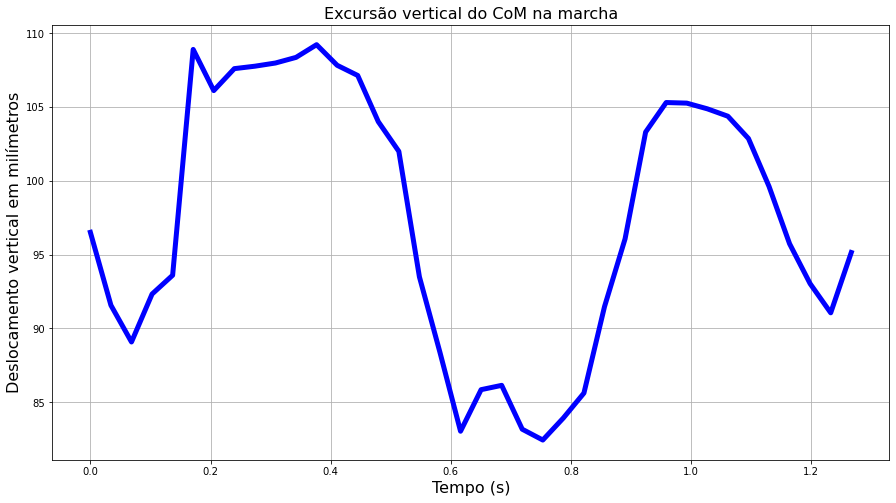

In [109]:
plt.figure(figsize=[15,8])
plt.plot(t, bodycom_Y, color = 'b', linewidth = 5)
plt.ylabel('Deslocamento vertical em milímetros', fontsize=16)
plt.xlabel('Tempo (s)', fontsize=16)
plt.title('Excursão vertical do CoM na marcha', fontsize=16)
plt.grid()
plt.show()

# Filtragem dos dados com filtro ButterWorth 

--> Em seguida, aplique o filtro de ButterWorth para suavizar as imperfeições do sinal.

In [110]:
import scipy.signal
import numpy as np
import matplotlib.pyplot as plt

--> O filtro passa-baixas foi estabelecido como 0.15 x Frequência de Nyquist, uma vez que representa a metade da frequência da câmera de vídeo, de 30 Hz.

In [111]:
# apply a 2-pole lowpass filter at 0.15x Nyquist frequency (15 hz is half the max frequency of the video (30Hz))
b, a = scipy.signal.butter(2, 0.2)
filtered = scipy.signal.filtfilt(b, a, bodycom_Y, axis=0)

--> Rode o bloco de código abaixo para observar a trajetória filtrada. Novamente, altere a legenda do eixo vertical quando necessário para diferenciar a escala sendo vista.

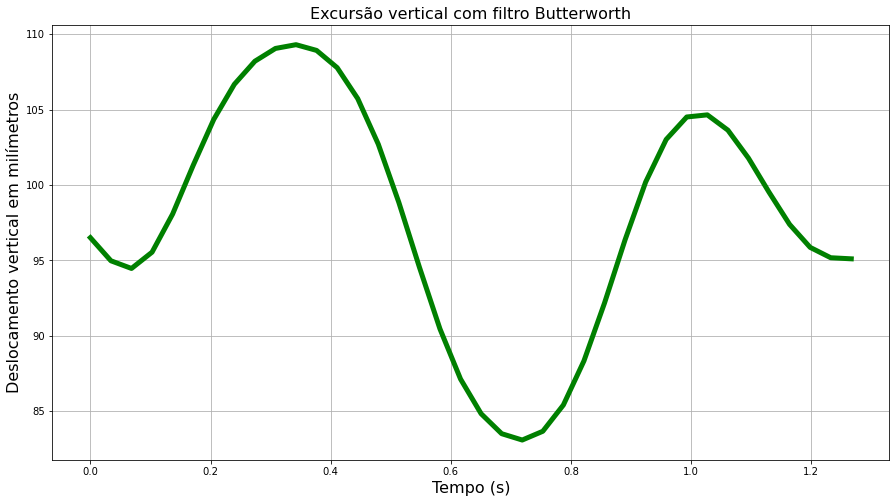

In [112]:
plt.figure(figsize=[15,8])
plt.plot(t, filtered, color = 'g', linewidth = 5)
plt.ylabel('Deslocamento vertical em milímetros', fontsize=16)
plt.xlabel('Tempo (s)', fontsize=16)
plt.title('Excursão vertical com filtro Butterworth', fontsize=16)
plt.grid()
plt.show()

--> Para analisar a sobreposição do sinal original com o filtrado, rode o código a seguir e altere a legenda do eixo vertical para se adequar a escala sendo vista.

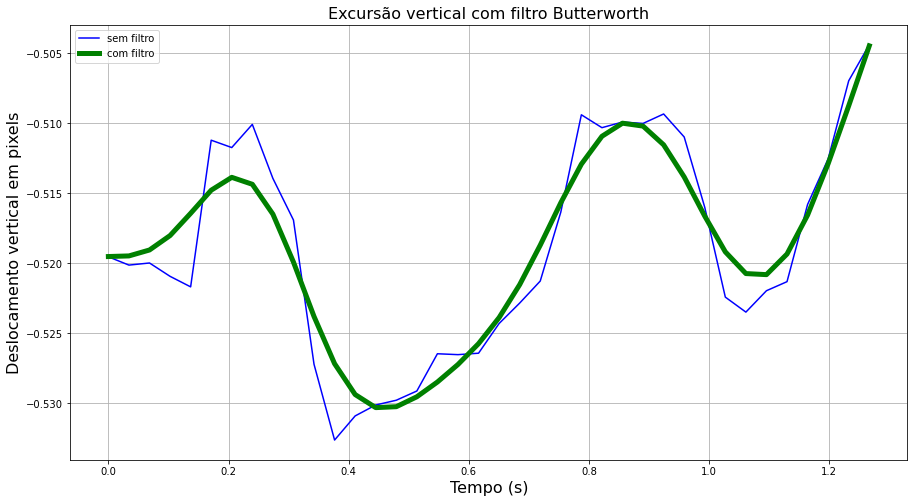

In [98]:
plt.figure(figsize=[15,8])
plt.plot(t, bodycom_Y, '-', color='blue', label="sem filtro")

for cutoff in [.2]:
    b, a = scipy.signal.butter(2, cutoff)
    filtered = scipy.signal.filtfilt(b, a, bodycom_Y, axis=0)
    label = f"{int(cutoff*100):d}%"
    plt.plot(t, filtered, color='green', label="com filtro", linewidth = 5)

plt.legend()
plt.ylabel('Deslocamento vertical em pixels', fontsize=16)
plt.xlabel('Tempo (s)', fontsize=16)
plt.title('Excursão vertical com filtro Butterworth', fontsize=16)
plt.grid()
plt.show()